# Wind exposure plot

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [27]:
import json
from datetime import datetime
from zoneinfo import ZoneInfo

import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as mtick

import numpy as np

from src.datasources.meteofr import (
    parse_track_json,
    prepare_wind_contours,
    expand_quad_col,
    calculate_wind_buffers_gdf,
    calculate_shifted_exposures,
)
from src.monitoring.plotting import plot_bullseye_exposures, plot_wind_buffers
from src.utils.exposure import calculate_multi_adm_exposure
from src.utils.blob_utils import PROJECT_PREFIX

## Load data

### CODAB

In [3]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3="mdg", admin_level=1)

<Axes: >

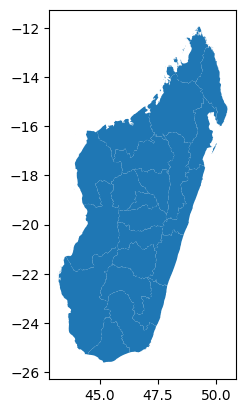

In [4]:
adm1.plot()

### Meteo France track forecast

In [ ]:
# from blob
blob_name = (
    "RSMC_LaReunion/CMRSTRACK_SWI$10_20252026_10-20252026_2026_02_07_12Z.json"
)
data = stratus.load_blob_data(blob_name, container_name="meteofr")

fcast_dict = json.loads(data)

In [5]:
# local file
local_path = "temp/CMRSTRACK_SWI$10_20252026_GEZANI_2026_02_09_18Z.json"

with open(local_path, "r", encoding="utf-8") as f:
    fcast_dict = json.load(f)

In [6]:
records, fc_details, uncertainty_cone = parse_track_json(fcast_dict)

In [7]:
speeds = [28, 34, 48, 64]

In [8]:
records = prepare_wind_contours(records)

for speed in speeds:
    col = f"wind_contour_{speed}kt"
    records = expand_quad_col(records, col)

In [9]:
records["lon"] = records.geometry.x
records["lat"] = records.geometry.y

### WP

In [10]:
blob_name = "worldpop/pop_count/global_pop_2026_CN_1km_R2025A_UA_v1.tif"
da_wp_global = stratus.open_blob_cog(blob_name, container_name="raster")

In [11]:
da_wp = da_wp_global.rio.clip(adm1.geometry).squeeze(drop=True).compute()

In [12]:
da_wp.attrs["_FillValue"] = None
da_wp = da_wp.where(da_wp > 0)

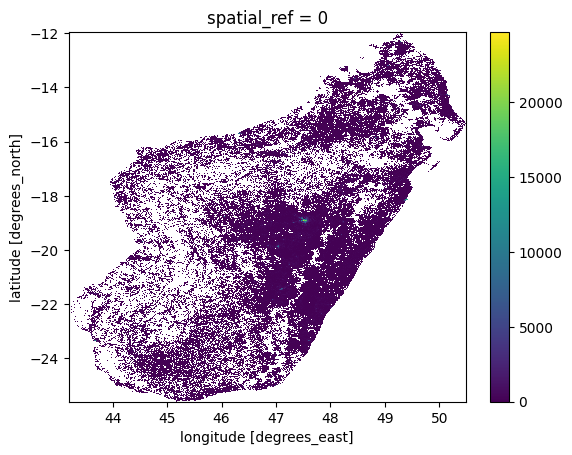

In [13]:
da_wp.plot()

In [14]:
da_wp.sum()

<xarray.DataArray ()> Size: 4B
array(32938792., dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     None

### Bubbles Template

In [15]:
blob_name = f"{PROJECT_PREFIX}/processed/plotting/adm1_template.parquet"
template_df = stratus.load_parquet_from_blob(blob_name)

## Calculate exposure

### Calculate wind buffers

In [16]:
gdf_buffers = calculate_wind_buffers_gdf(
    records,
    valid_time_col="time",
    quad_cols_format="wind_contour_{speed}kt_{quad}",
    lat_col="lat",
    lon_col="lon",
    speeds=speeds,
)

In [17]:
gdf_buffers

,speed,geometry
0,28,"MULTIPOLYGON (((4403582.445 -2952041.425, 4405..."
1,34,"POLYGON ((4237840.753 -2936907.634, 4239052.13..."
2,48,"MULTIPOLYGON (((4142337.879 -3014914.949, 4143..."
3,64,"MULTIPOLYGON (((4110351.228 -3026804.17, 41108..."


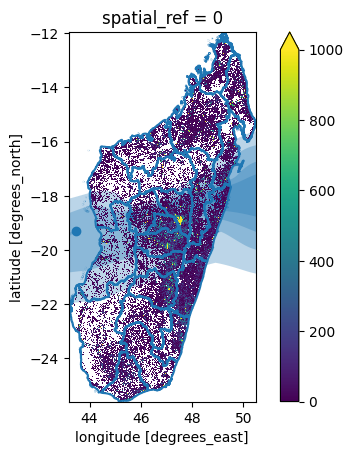

In [18]:
fig, ax = plt.subplots()
gdf_buffers.to_crs(4326).plot(ax=ax, alpha=0.3)
records.plot(ax=ax)
adm1.boundary.plot(ax=ax)
da_wp.plot(ax=ax, vmax=1000)

### Overlay and calculate exposure

In [19]:
df_exp = calculate_multi_adm_exposure(
    gdf_buffers, da_wp, adm1, adm_index="adm1_src", disable_tqdm=False
)

  0%|          | 0/22 [00:00<?, ?it/s]

In [20]:
df_exp

,speed,pop_exposed,adm1_src
0,28,4609260,MG11
1,34,4590073,MG11
2,48,625880,MG11
3,64,368209,MG11
4,28,2706843,MG12
...,...,...,...
83,64,0,MG71
84,28,14982,MG72
85,34,0,MG72
86,48,0,MG72


In [21]:
df_exp["speed_kmh"] = (df_exp["speed"] * 1.852).astype(int)

In [22]:
df_exp["speed_kmh"].unique()

array([ 51,  62,  88, 118])

In [23]:
df_exp

,speed,pop_exposed,adm1_src,speed_kmh
0,28,4609260,MG11,51
1,34,4590073,MG11,62
2,48,625880,MG11,88
3,64,368209,MG11,118
4,28,2706843,MG12,51
...,...,...,...,...
83,64,0,MG71,118
84,28,14982,MG72,51
85,34,0,MG72,62
86,48,0,MG72,88


## Calculate perturbed exposures

In [24]:
records = records.set_crs(4326)

In [28]:
(
    df_exp_shift,
    gdf_shift_buffers,
    gdf_shift_tracks,
) = calculate_shifted_exposures(
    records,
    da_wp,
    disable_tqdm=False,
    time_col="time",
    lat_col="lat",
    lon_col="lon",
    quad_cols_format="wind_contour_{speed}kt_{quad}",
    speeds=speeds,
)

  0%|          | 0/36 [00:00<?, ?it/s]

In [29]:
df_exp_shift = df_exp_shift.sort_values(
    [f"exp_{x}" for x in sorted(speeds, reverse=True)], ascending=False
)
worst_row = df_exp_shift.iloc[0].copy()
worst_row["level"] = "worst"
best_row = df_exp_shift.iloc[-1].copy()
best_row["level"] = "best"

In [30]:
df_exp_shift

,shift_deg,exp_28,exp_34,exp_48,exp_64
23,230,17250880,12881665,7867428,6593189
24,240,16930066,13077474,7962986,6472660
22,220,17512702,12820445,7945882,6253016
25,250,16596314,12998198,7976565,3533604
21,210,17440356,12626700,7227391,3086272
29,290,15524007,10271638,3124606,2378179
30,300,15486699,8332836,2932895,2365039
31,310,15257598,5713511,2867441,2314105
28,280,15560226,10829672,3329605,2258949
26,260,16377468,12208577,6866223,2258435


In [32]:
# Calculate best and worst case adm3 exposures
gdf_shift_buffers["speed_kmh"] = (gdf_shift_buffers["speed"] * 1.852).astype(
    int
)

worst_buffers = gdf_shift_buffers[
    gdf_shift_buffers["shift_deg"] == worst_row["shift_deg"]
]
best_buffers = gdf_shift_buffers[
    gdf_shift_buffers["shift_deg"] == best_row["shift_deg"]
]


df_exp_adm1_worst = calculate_multi_adm_exposure(
    worst_buffers, da_wp, adm1, adm_index="adm1_src", disable_tqdm=False
)

df_exp_adm1_best = calculate_multi_adm_exposure(
    best_buffers, da_wp, adm1, adm_index="adm1_src", disable_tqdm=False
)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

## Plot

In [35]:
colors = {51: "gold", 62: "darkorange", 88: "crimson", 118: "indigo"}

In [36]:
colors.keys()

dict_keys([51, 62, 88, 118])

In [37]:
fc_details

{'cyclone_name': 'GEZANI',
 'season': 20252026,
 'reference_time': '2026-02-09T18:00:00Z',
 'basin': 'SWI'}

In [38]:
def dt_to_EAT(s):
    dt_utc = datetime.fromisoformat(s.replace("Z", "+00:00"))
    return dt_utc.astimezone(ZoneInfo("Africa/Nairobi"))

In [39]:
dt_eat = dt_to_EAT(fc_details["reference_time"])

In [40]:
issued_time_str = dt_eat.strftime("%Y-%m-%d %H:%M")

In [41]:
gdf_buffers["speed_kmh"] = (gdf_buffers["speed"] * 1.852).astype(int)

In [46]:
def plot_both_exp(
    gdf_tracks_plot, gdf_buffers_plot, df_exp_plot, forecast_label: str = ""
):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(12, 8),
        dpi=200,
    )

    fig_size = (9, 8)

    plot_wind_buffers(
        adm1,
        gdf_buffers_plot,
        colors=colors,
        speed_unit="km/h",
        speed_col="speed_kmh",
        ax=ax1,
        fig_size=fig_size,
        show_labels=True,
    )

    xs = gdf_tracks_plot.geometry.x.values
    ys = gdf_tracks_plot.geometry.y.values

    # line first (under points)
    ax1.plot(
        xs,
        ys,
        color="black",
        linewidth=1.5,
        zorder=9,
    )

    # points on top
    gdf_tracks_plot.plot(
        ax=ax1,
        color="black",
        markersize=20,
        zorder=10,
    )

    gpd.GeoSeries([uncertainty_cone], crs=adm1.crs).plot(
        ax=ax1,
        facecolor="none",
        edgecolor="grey",
        linewidth=1.5,
        linestyle="--",
        zorder=10,
    )

    existing_legend = ax1.get_legend()
    if existing_legend is not None:
        ax1.add_artist(existing_legend)

    # --- build proxy artists for track & cone ---
    track_handle = Line2D(
        [0],
        [0],
        color="black",
        linewidth=1.5,
        label=forecast_label,
    )

    cone_handle = Patch(
        facecolor="none",
        edgecolor="grey",
        linewidth=1.5,
        linestyle="--",
        label="Uncertainty cone",
    )

    # --- second legend ---
    legend_track = ax1.legend(
        handles=[track_handle, cone_handle],
        loc="upper right",
        fontsize=7,
        frameon=True,
    )

    ax1.add_artist(legend_track)

    ax1.set_title(
        "Geographic exposure (wind buffers)",
        fontsize=9,
        fontweight="bold",
    )

    plot_bullseye_exposures(
        template_df,
        df_exp_plot,
        label_col="adm_label",
        id_col="adm1_src",
        speed_col="speed_kmh",
        min_font=8,
        max_font=20,
        speeds_order=colors.keys(),
        colors=colors,
        speed_unit="km/h",
        ax=ax2,
        fig_size=fig_size,
    )

    ax2.set_title(
        "Population exposure by region",
        fontsize=9,
        fontweight="bold",
    )

    fig.suptitle(
        f'Madagascar: exposure to "{fc_details["cyclone_name"]}" wind speed',
        fontsize=12,
        y=0.98,
    )

    fig.text(
        0.5,
        0.93,
        f"Forecast issued: {issued_time_str} (EAT) • {forecast_label}",
        ha="center",
        fontsize=10,
        style="italic",
    )

    fig.subplots_adjust(wspace=-0.1)

    return fig, (ax1, ax2)

(<Figure size 2400x1600 with 2 Axes>,
 (<Axes: title={'center': 'Geographic exposure (wind buffers)'}>,
  <Axes: title={'center': 'Population exposure by region'}>))

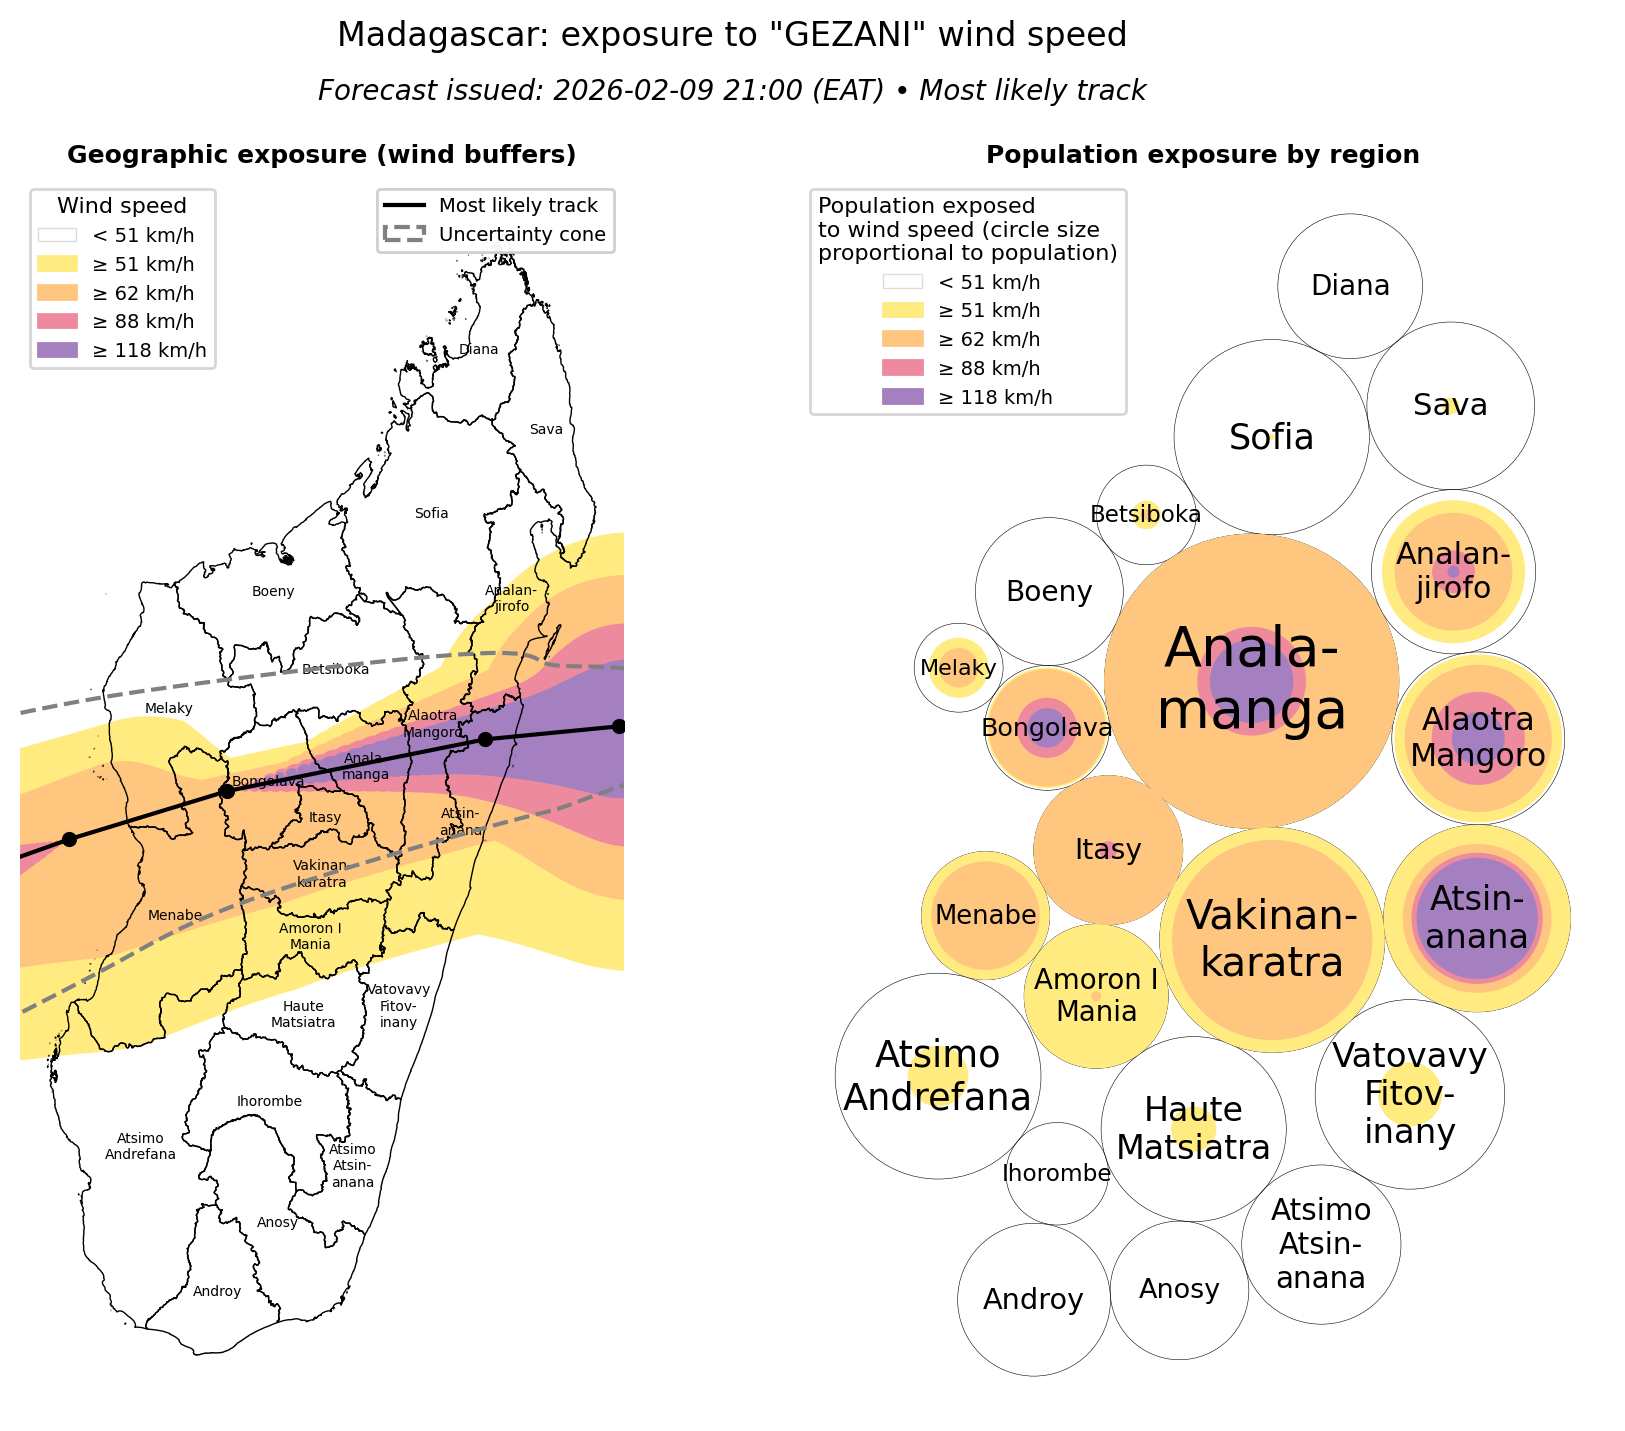

In [47]:
plot_both_exp(
    gdf_tracks_plot=records,
    gdf_buffers_plot=gdf_buffers,
    df_exp_plot=df_exp,
    forecast_label="Most likely track",
)

(<Figure size 2400x1600 with 2 Axes>,
 (<Axes: title={'center': 'Geographic exposure (wind buffers)'}>,
  <Axes: title={'center': 'Population exposure by region'}>))

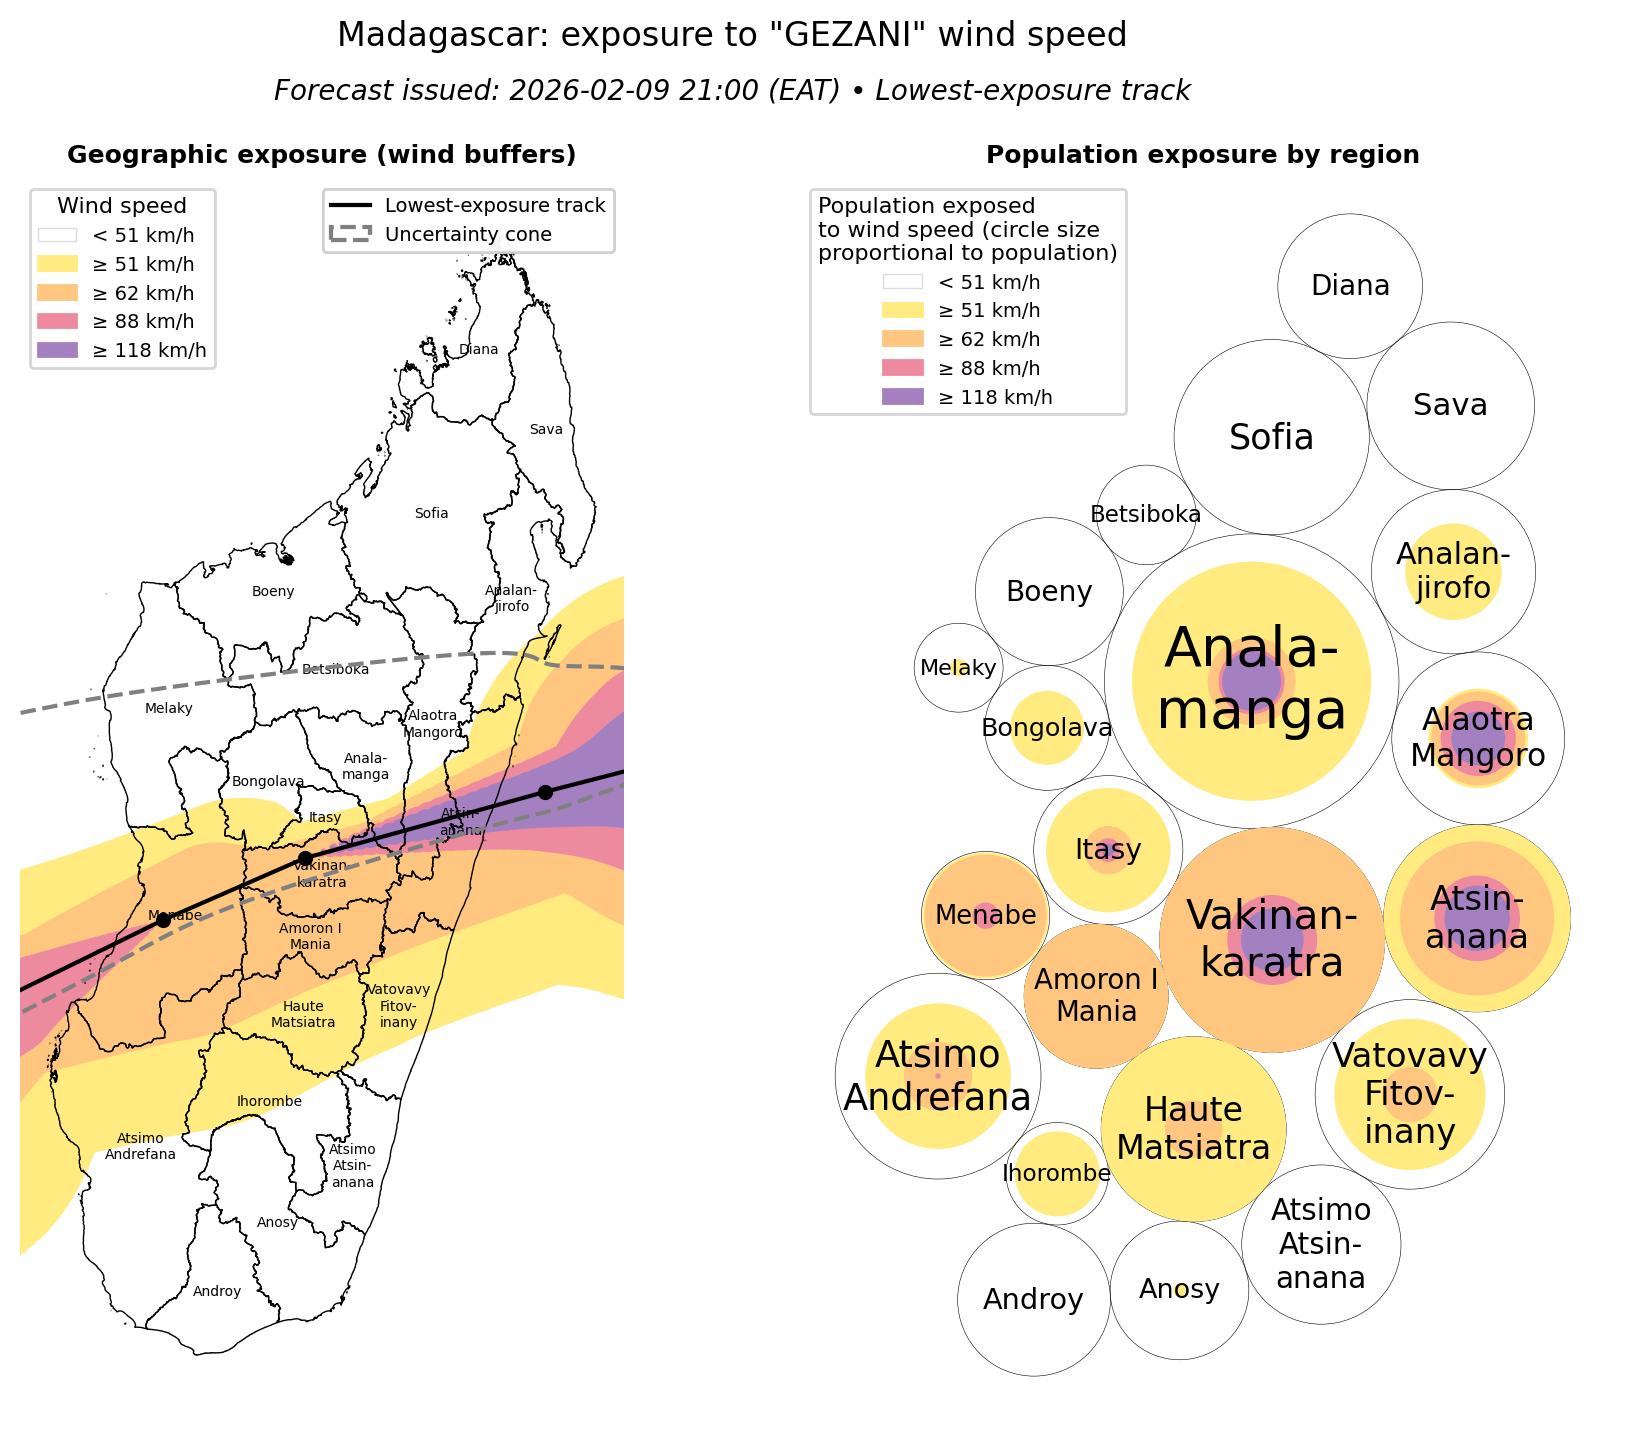

In [48]:
plot_both_exp(
    gdf_tracks_plot=gdf_shift_tracks[
        gdf_shift_tracks["shift_deg"] == best_row["shift_deg"]
    ],
    gdf_buffers_plot=best_buffers,
    df_exp_plot=df_exp_adm1_best,
    forecast_label="Lowest-exposure track",
)

(<Figure size 2400x1600 with 2 Axes>,
 (<Axes: title={'center': 'Geographic exposure (wind buffers)'}>,
  <Axes: title={'center': 'Population exposure by region'}>))

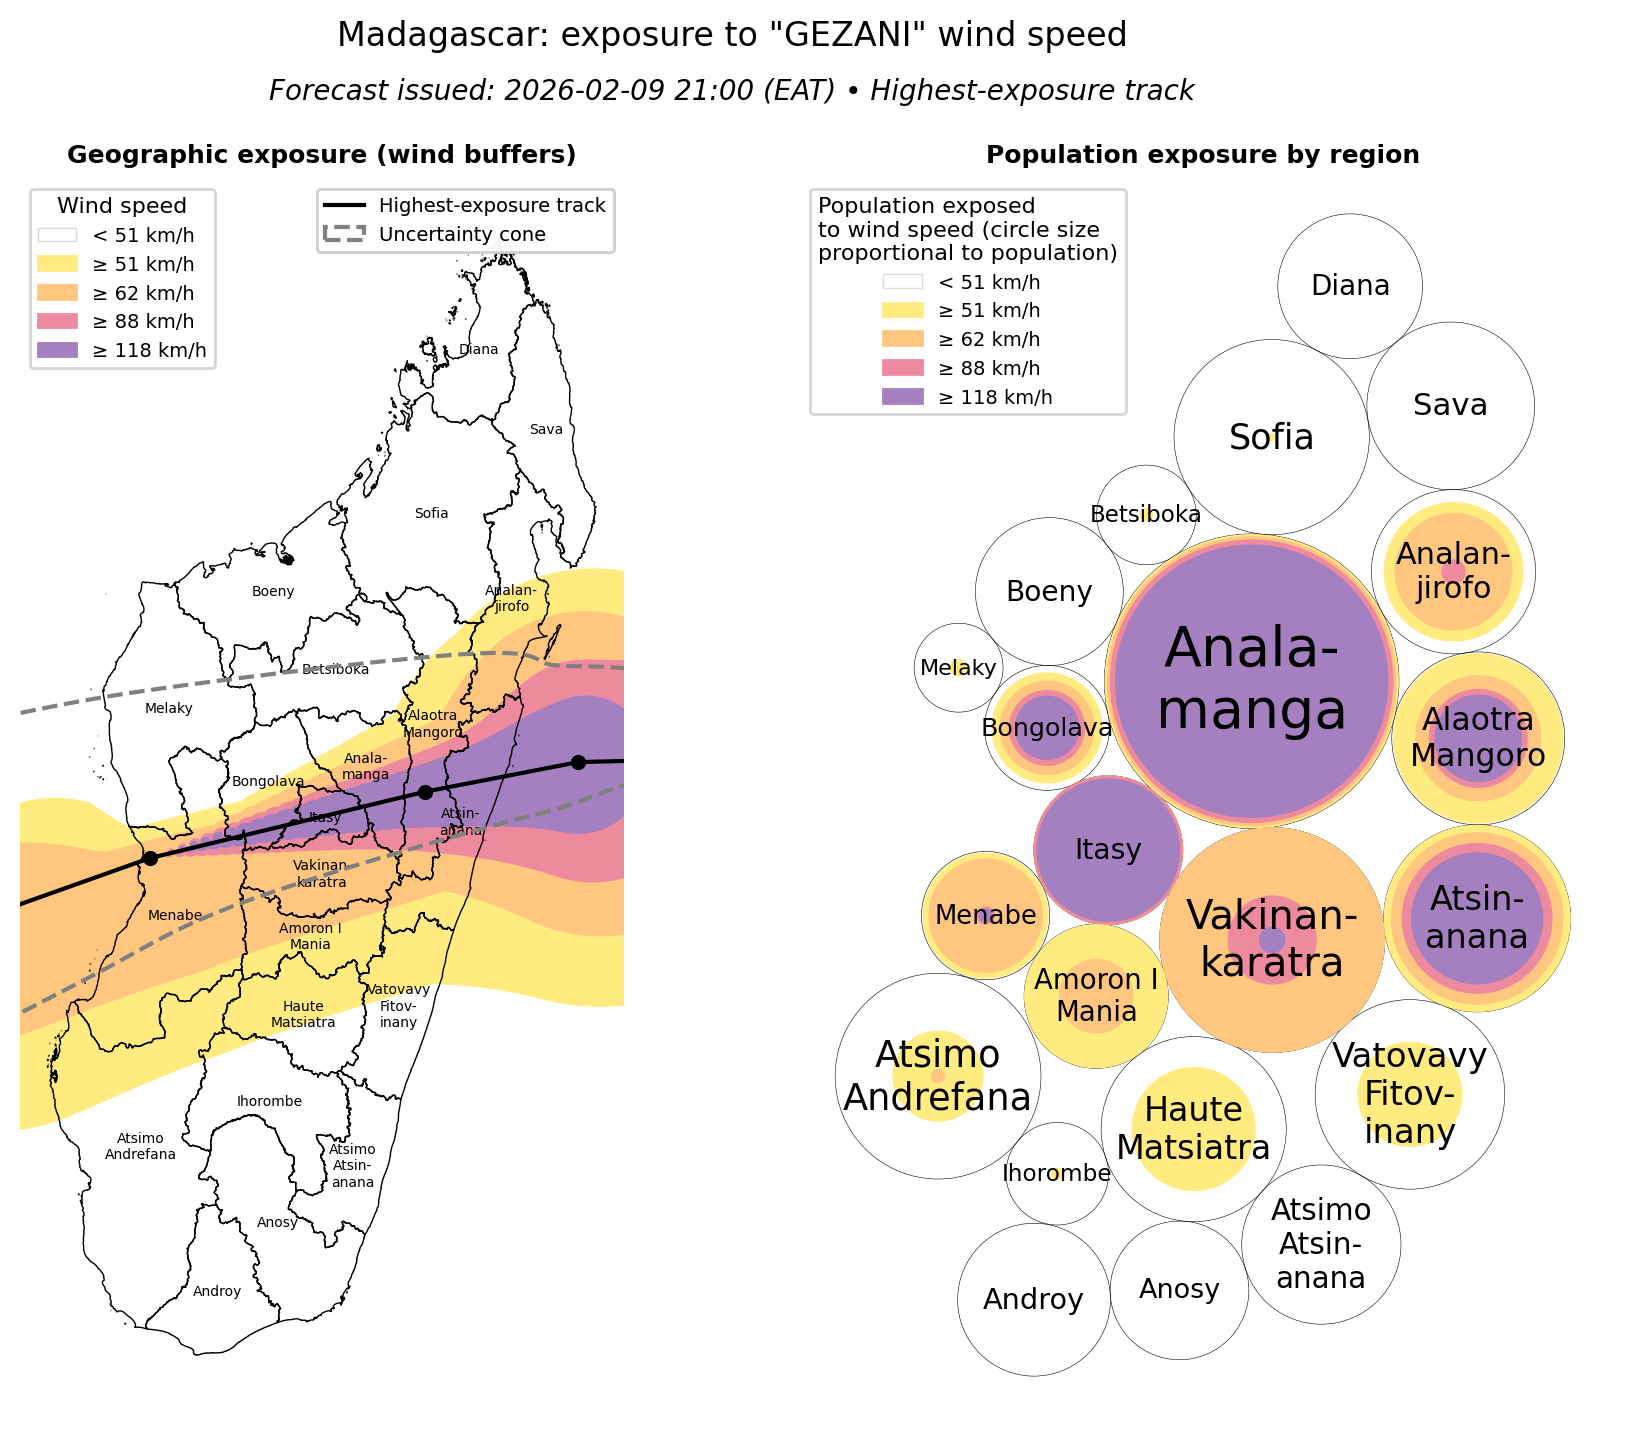

In [49]:
plot_both_exp(
    gdf_tracks_plot=gdf_shift_tracks[
        gdf_shift_tracks["shift_deg"] == worst_row["shift_deg"]
    ],
    gdf_buffers_plot=worst_buffers,
    df_exp_plot=df_exp_adm1_worst,
    forecast_label="Highest-exposure track",
)

In [244]:
sorted(speeds_kmh, reverse=True)

[118, 88, 62, 51]

In [245]:
df_exp_pivot = df_exp.merge(adm1[["adm1_src", "adm1_name"]]).pivot(
    index="adm1_name", columns="speed_kmh", values="pop_exposed"
)

In [246]:
df_exp_pivot["≥ 118 km/h"] = df_exp_pivot[118]
df_exp_pivot["≥ 88 km/h"] = df_exp_pivot[88] - df_exp_pivot[118]
df_exp_pivot["≥ 62 km/h"] = df_exp_pivot[62] - df_exp_pivot[88]
df_exp_pivot["≥ 51 km/h"] = df_exp_pivot[51] - df_exp_pivot[62]

df_exp_pivot = df_exp_pivot.sort_values(51)

In [247]:
df_exp_pivot

speed_kmh,51,62,88,118,≥ 118 km/h,≥ 88 km/h,≥ 62 km/h,≥ 51 km/h
adm1_name,,,,,,,,
Boeny,0,0,0,0,0,0,0,0
Androy,0,0,0,0,0,0,0,0
Anosy,0,0,0,0,0,0,0,0
Atsimo Atsinanana,0,0,0,0,0,0,0,0
Ihorombe,0,0,0,0,0,0,0,0
Diana,0,0,0,0,0,0,0,0
Sofia,1890,0,0,0,0,0,0,1890
Sava,14982,0,0,0,0,0,0,14982
Betsiboka,43512,6272,0,0,0,0,6272,37240


In [248]:
colors_bar = {f"≥ {x} km/h": y for x, y in colors.items()}

In [249]:
colors_bar

{'≥ 51 km/h': 'gold',
 '≥ 62 km/h': 'darkorange',
 '≥ 88 km/h': 'crimson',
 '≥ 118 km/h': 'indigo'}

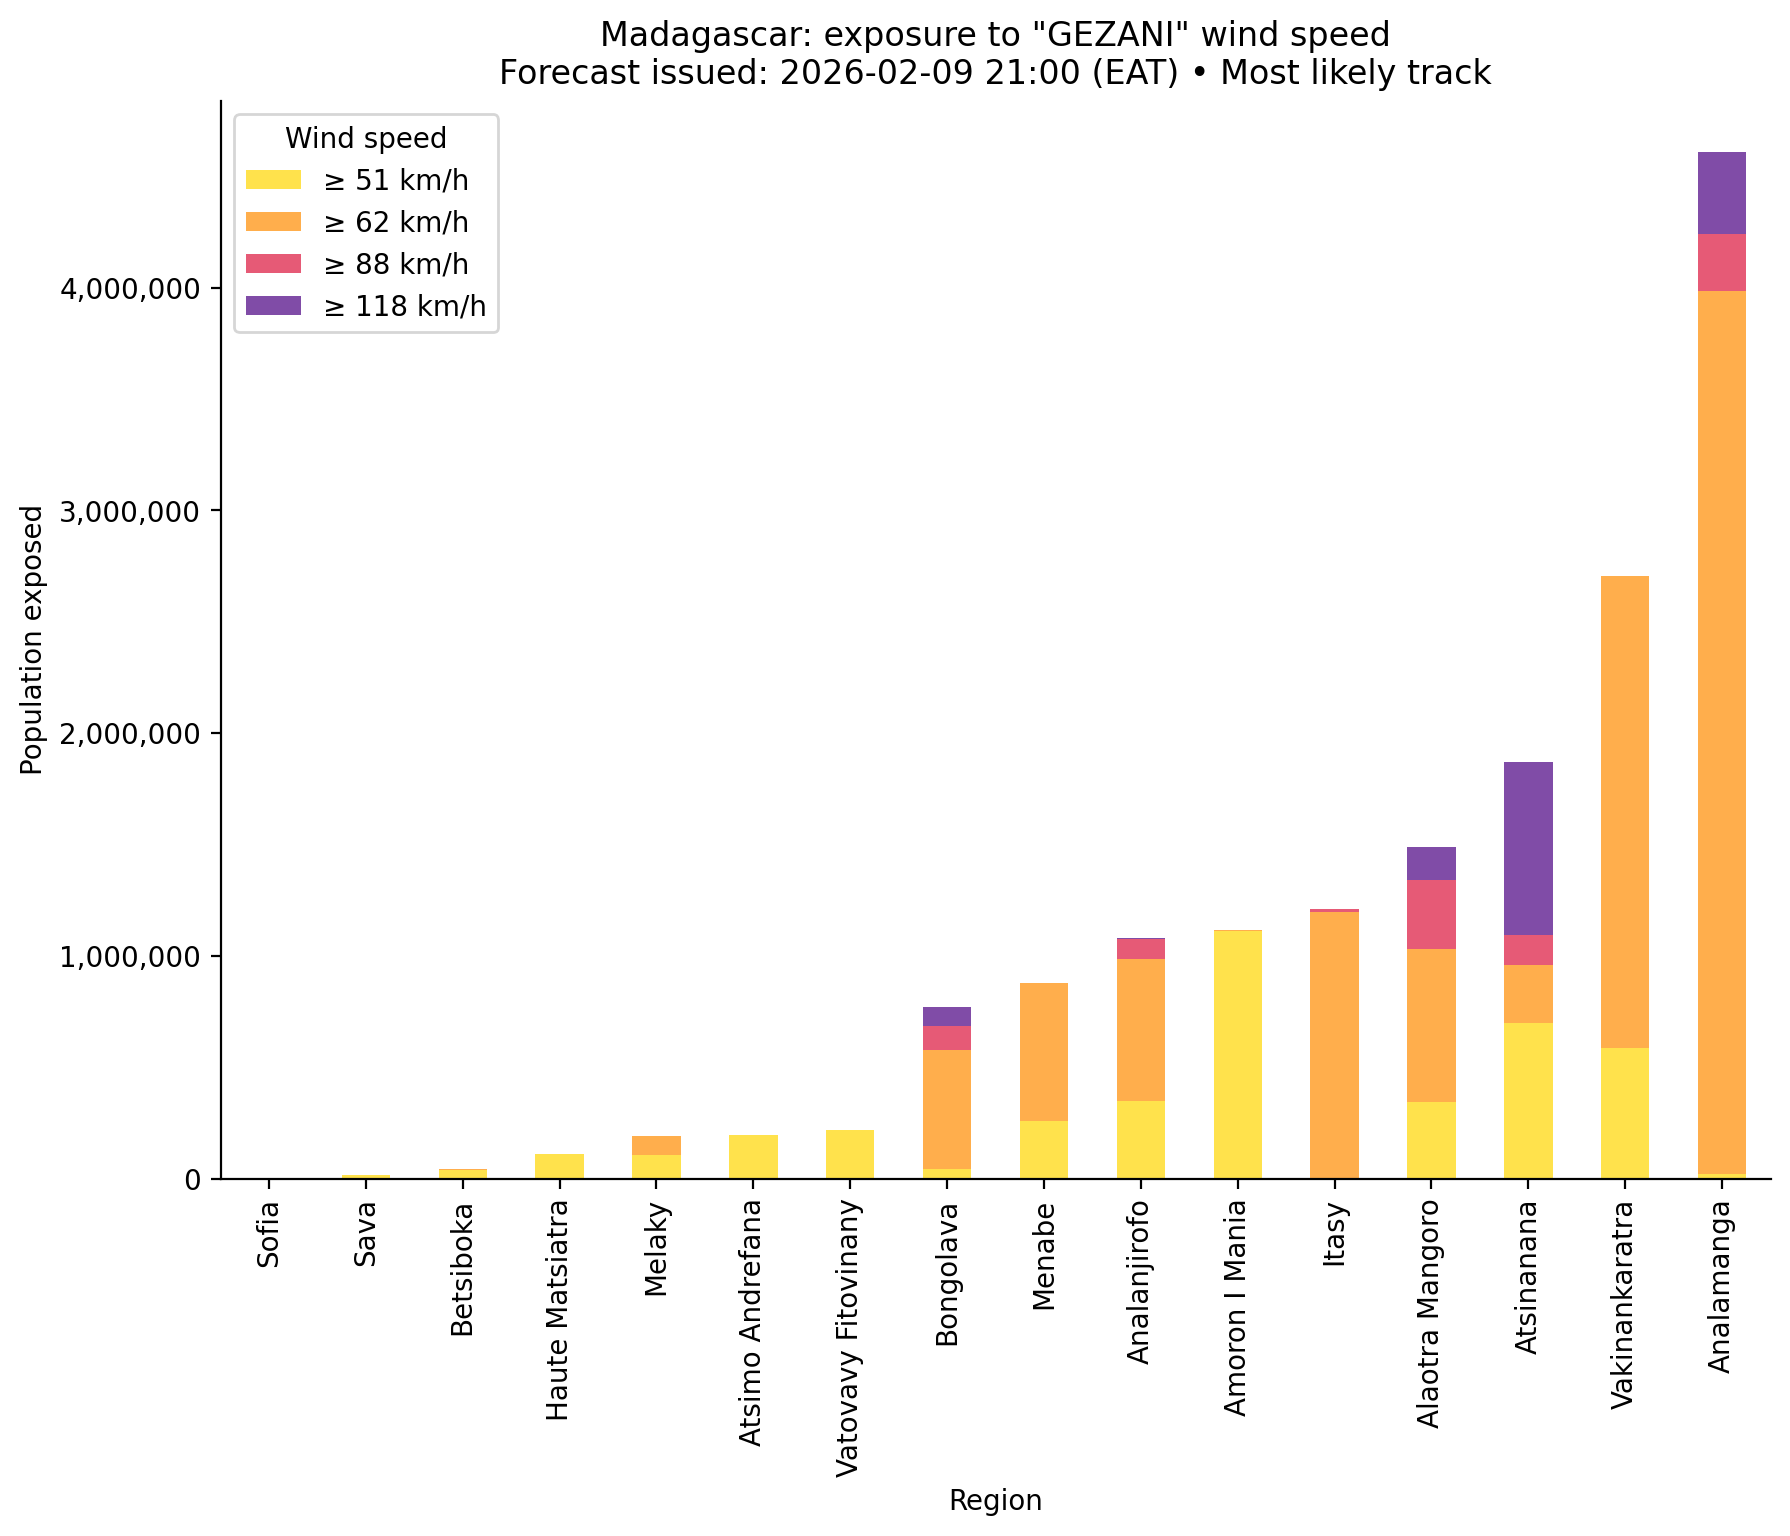

In [250]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 7))

cols = [f"≥ {x} km/h" for x in speeds_kmh]

df_exp_pivot[df_exp_pivot[51] > 0][cols].plot.bar(
    ax=ax, color=colors_bar, stacked=True, alpha=0.7
)

[ax.spines[x].set_visible(False) for x in ["top", "right"]]
ax.set_xlabel("Region")
ax.set_ylabel("Population exposed")
ax.set_title(
    f'Madagascar: exposure to "{fc_details["cyclone_name"]}" wind speed\n'
    f"Forecast issued: {issued_time_str} (EAT) • Most likely track"
)

ax.legend(title="Wind speed")

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

In [251]:
dt_utc = datetime.fromisoformat(fc_details["reference_time"])

In [252]:
issued_time_str = dt_utc.strftime("%Y%m%dT%H%MZ")

In [253]:
issued_time_str

'20260209T1800Z'

In [254]:
df_out = (
    df_exp.merge(adm1[["adm1_src", "adm1_name"]])
    .pivot(
        columns="speed_kmh",
        index=["adm1_src", "adm1_name"],
        values="pop_exposed",
    )
    .reset_index()
)
df_out.columns.name = None
df_out = df_out.sort_values("adm1_name")
df_out = df_out.rename(columns={x: f"exp_{x}_kmh" for x in [51, 62, 88, 118]})
df_out

,adm1_src,adm1_name,exp_51_kmh,exp_62_kmh,exp_88_kmh,exp_118_kmh
11,MG33,Alaotra Mangoro,1489403,1146238,460358,147419
5,MG22,Amoron I Mania,1115781,5544,0,0
0,MG11,Analamanga,4609260,4590073,625880,368209
10,MG32,Analanjirofo,1081892,734816,96920,7677
17,MG52,Androy,0,0,0,0
18,MG53,Anosy,0,0,0,0
16,MG51,Atsimo Andrefana,194412,0,0,0
8,MG25,Atsimo Atsinanana,0,0,0,0
9,MG31,Atsinanana,1868822,1171456,910873,777165
14,MG43,Betsiboka,43512,6272,0,0


In [255]:
out_path = f'temp/{fc_details["cyclone_name"].lower()}_issued_{issued_time_str}_mdg_adm1_exposure.csv'
out_path

'temp/gezani_issued_20260209T1800Z_mdg_adm1_exposure.csv'

In [256]:
df_out.to_csv(out_path, index=False)